<a href="https://colab.research.google.com/github/shambhavisud/Naruto-Friends-Quiz/blob/master/final_Machine_Translation_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import string
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
import os
import time
import seaborn as sns
import pandas as pd

In [ ]:

n_size_batch = 64
n_size_buffer = n_size_batch*4
len_dcdr = 100
len_enc = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Data Preprocessing
<h2>Loading Files</h2>
To improve performance of the model, I filtered and deleted phrases that either alot of characters or only a few of them. Both Hindi & English sentences were then tokenized & padded to the fixed length.

[link to data](https://www.kaggle.com/aiswaryaramachandran/hindienglish-corpora)

In [ ]:
to_df_trn = pd.read_csv("/content/drive/My Drive/translation_files/Hindi_English_Truncated_Corpus.csv")
to_df_trn.drop(['source'],axis=1,inplace=True)
mask = (to_df_trn['english_sentence'].str.len()>20) & (to_df_trn['english_sentence'].str.len()<200)
to_df_trn = to_df_trn.loc[mask]
to_df_trn = to_df_trn.sample(64000, random_state=1)
to_df_trn.head()


In [ ]:
pd.set_option('display.max_colwidth', None)


In [ ]:
English = to_df_trn['english_sentence']
Hindi = to_df_trn['hindi_sentence']
English = English.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
Hindi = Hindi.apply(lambda x: "<SOS> "+ x + " <EOS>")

# Tokenizing Text

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
tkniser_en = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tkniser_hi = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tkniser_en.fit_on_texts(English)
tkniser_hi.fit_on_texts(Hindi)
ips = tkniser_en.texts_to_sequences(English)
i_trgts = tkniser_hi.texts_to_sequences(Hindi)

In [ ]:
vocab_encdr = len(tkniser_en.word_index) + 1
vocab_dcdr = len(tkniser_hi.word_index) + 1
print(vocab_encdr, vocab_dcdr)

44305 51960


# Inputs/outputs creation
As we train with batches, we need each input to have the same length. We pad with the appropriate token, and we will make sure this padding token doesn't interfere with our training later.

In [ ]:
ips = tf.keras.preprocessing.sequence.pad_sequences(ips, maxlen=len_enc, padding='post', truncating='post')
i_trgts = tf.keras.preprocessing.sequence.pad_sequences(i_trgts, maxlen=len_dcdr, padding='post', truncating='post')
ips = tf.cast(ips, dtype=tf.int64)
i_trgts = tf.cast(i_trgts, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((ips, i_trgts)).shuffle(n_size_buffer).batch(n_size_batch)

# Transformer Model Building
Here I build a Transformer from scratch.


## Embedding


In [ ]:
def fetch_angles(position, i, d_model):
    rts_angle = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * rts_angle

def encd_position(position, d_model):
    rds_angl = fetch_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    rds_angl[:, 0::2] = np.sin(rds_angl[:, 0::2])

    rds_angl[:, 1::2] = np.cos(rds_angl[:, 1::2])

    encd_pos = rds_angl[np.newaxis, ...]

    return tf.cast(encd_pos, dtype=tf.float32)

def make_msk_padding(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def make_msk_look_ahead(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask



# Attention computation

$Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

Q, K and V are matrices representing sequences/sentences after embedding. Q is my context sequence B. we divide by dk which is the dimension of each element from each word to the key, it makes the model more stable.</br>




In [ ]:
def attn_dot_prod_scld(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    attn_logits_scld = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        attn_logits_scld += (mask * -1e9)  

    wts_attn = tf.nn.softmax(attn_logits_scld, axis=-1)

    output = tf.matmul(wts_attn, v)
    return output, wts_attn

# Multi-head attention sublayer

In [ ]:
class attn_mlti_hds(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(attn_mlti_hds, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def hd_splt(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.hd_splt(q, batch_size)
        k = self.hd_splt(k, batch_size)
        v = self.hd_splt(v, batch_size)

        attn_scld, wts_attn = attn_dot_prod_scld(
            q, k, v, mask)

        attn_scld = tf.transpose(attn_scld, perm=[0, 2, 1, 3])
        
        attn_concat = tf.reshape(attn_scld, (batch_size, -1, self.d_model))
        output = self.dense(attn_concat)
            
        return output, wts_attn
    
def ffnn_pt_wise(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

# Encoder
Positional encoding formulae:

$PE_{(pos, 2i)} = \sin(pos/10000^{2i/dmodel})$

$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/dmodel})$

In [ ]:
class lr_encdr(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(lr_encdr, self).__init__()

        self.mha = attn_mlti_hds(d_model, num_heads)
        self.ffn = ffnn_pt_wise(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Decoder

In [ ]:
class lr_dcdr(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(lr_dcdr, self).__init__()

        self.mha1 = attn_mlti_hds(d_model, num_heads)
        self.mha2 = attn_mlti_hds(d_model, num_heads)

        self.ffn = ffnn_pt_wise(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, op_enc, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(op_enc, op_enc, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, encd_position_max, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.encd_pos = encd_position(encd_position_max, self.d_model)

        self.enc_layers = [lr_encdr(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.encd_pos[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, encd_position_max, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.encd_pos = encd_position(encd_position_max, d_model)

        self.dec_layers = [lr_dcdr(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, op_enc, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        wts_attn = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.encd_pos[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, op_enc, training, look_ahead_mask, padding_mask)

            wts_attn['decoder_layer{}_block1'.format(i+1)] = block1
            wts_attn['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, wts_attn

# Transformer
[link](https://www.tensorflow.org/text/tutorials/transformer) to tutorial i used for building the Transformer from scratch

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, msk_encdr_padding, look_ahead_mask, msk_dcdr_padding):
        op_enc = self.encoder(inp, training, msk_encdr_padding)

        op_dcdr, wts_attn = self.decoder(tar, op_enc, training, look_ahead_mask, msk_dcdr_padding)

        op_resultant = self.final_layer(op_dcdr)

        return op_resultant, wts_attn


# Application

In [ ]:
nepochs = 20
#nepochs = 10
d_model = 128
num_layers = 4
#nepochs = 10
num_heads = 8
dff = 512
#nepochs = 10
dropout_rate = 0.1


# Custom Learning Rate

In [ ]:
class sched_custm(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(sched_custm, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
rt_of_lrning = sched_custm(d_model)

optimizer = tf.keras.optimizers.Adam(rt_of_lrning, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

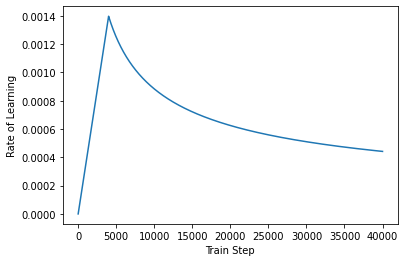

In [ ]:
sched_tmp_lrng_rate = sched_custm(d_model)

plt.plot(sched_tmp_lrng_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Rate of Learning")
plt.xlabel("Train Step")

# Custom Accuracy & Loss

In [ ]:
obj_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def func_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = obj_loss(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def func_acc(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
loss_tr = tf.keras.metrics.Mean(name='loss_tr')
acc_tr = tf.keras.metrics.Mean(name='acc_tr')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_encdr,
    target_vocab_size=vocab_dcdr,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def make_msk(inp, tar):
    msk_encdr_padding = make_msk_padding(inp)
    msk_dcdr_padding = make_msk_padding(inp)

    look_ahead_mask = make_msk_look_ahead(tf.shape(tar)[1])
    dec_target_padding_mask = make_msk_padding(tar)
    msk_comb = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return msk_encdr_padding, msk_comb, msk_dcdr_padding

In [ ]:
dir_chkpt = "checkpoints"

chkpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

mngr_chkpt = tf.train.CheckpointManager(chkpt, dir_chkpt, max_to_keep=5)

if mngr_chkpt.latest_checkpoint:
    chkpt.restore(mngr_chkpt.latest_checkpoint)
    print ('updated chkpoint test')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    msk_encdr_padding, msk_comb, msk_dcdr_padding = make_msk(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            msk_encdr_padding, 
            msk_comb, 
            msk_dcdr_padding
        )
        loss = func_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    loss_tr(loss)
    acc_tr(func_acc(tar_real, predictions))

#Model Training

In [ ]:
for epoch in range(nepochs):
    time_init = time.time()

    loss_tr.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} acc {acc_tr.result():.4f} loss {loss_tr.result():.4f} batch_no. {batch}  ')
      
    if (epoch + 1) % 5 == 0:
        dir_chkpt_save = mngr_chkpt.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, dir_chkpt_save))
   
    print(f'Epoch {epoch + 1} acc {acc_tr.result():.4f} loss {loss_tr.result():.4f}')
    print ('Single epoch took : {} seconds\n'.format(time.time() - time_init))

Epoch 1 acc 0.0000 loss 10.8629 batch_no. 0  
Epoch 1 acc 0.0427 loss 10.5080 batch_no. 200  
Epoch 1 acc 0.0517 loss 9.6748 batch_no. 400  
Epoch 1 acc 0.0560 loss 8.9393 batch_no. 600  
Epoch 1 acc 0.0644 loss 8.4868 batch_no. 800  
Epoch 1 acc 0.0736 loss 8.1596
Single epoch took : 565.278332233429 seconds

Epoch 2 acc 0.0737 loss 6.8752 batch_no. 0  
Epoch 2 acc 0.0823 loss 6.6362 batch_no. 200  
Epoch 2 acc 0.0900 loss 6.5562 batch_no. 400  
Epoch 2 acc 0.0972 loss 6.4826 batch_no. 600  
Epoch 2 acc 0.1036 loss 6.4118 batch_no. 800  
Epoch 2 acc 0.1095 loss 6.3461
Single epoch took : 553.7737319469452 seconds

Epoch 3 acc 0.1095 loss 5.8160 batch_no. 0  
Epoch 3 acc 0.1150 loss 5.9772 batch_no. 200  
Epoch 3 acc 0.1201 loss 5.9220 batch_no. 400  
Epoch 3 acc 0.1251 loss 5.8709 batch_no. 600  
Epoch 3 acc 0.1298 loss 5.8211 batch_no. 800  
Epoch 3 acc 0.1342 loss 5.7760
Single epoch took : 554.051075220108 seconds

Epoch 4 acc 0.1342 loss 5.4537 batch_no. 0  
Epoch 4 acc 0.1384 los

In [ ]:
def mod_eval(text):
    text = tkniser_en.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=len_enc, 
                                                                   padding='post', truncating='post')

    ip_encdr = tf.expand_dims(text[0], 0)

    ip_dcrdr = [tkniser_hi.word_index['<sos>']]
    output = tf.expand_dims(ip_dcrdr, 0)
    
    for i in range(len_dcdr):
        msk_encdr_padding, msk_comb, msk_dcdr_padding = make_msk(ip_encdr, output)

        predictions, wts_attn = transformer(
            ip_encdr, 
            output,
            False,
            msk_encdr_padding,
            msk_comb,
            msk_dcdr_padding
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == tkniser_hi.word_index['<eos>']:
            return tf.squeeze(output, axis=0), wts_attn

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), wts_attn

In [ ]:
def translate(txtin_english):
    txtin_hindi = mod_eval(text=txtin_english)[0].numpy()
    txtin_hindi = np.expand_dims(txtin_hindi[1:], 0)  
    return tkniser_hi.sequences_to_texts(txtin_hindi)[0]

# Predictions

In [ ]:
translate("My name is Shambhavi.")


'मेरा नाम तमिल नाम है।'

In [ ]:
translate("It's a beautiful place.")

'यह एक छोटी इमारतें है खास तौर पर बहुत बड़ा है।'

In [ ]:
translate("She gave him a watch.")

'वो एक महान उपहार थे ।'

In [ ]:
translate("thank you")

'धन्यवाद धन्यवाद धन्यवाद धन्यवाद धन्यवाद धन्यवाद धन्यवाद'

In [ ]:
translate("Where do we go?")

'जहाँ हम कहाँ कहाँ करते हैं'

In [ ]:
translate("I am going home.")

'मैं घर घर में बाहर जाती हूँ'

In [ ]:
translate("I have to go.")

'मुझे हमेशा देखना होगा'

In [ ]:
translate("That is a cat.")

'कि ये एक रंग है जिसमें कि एक रंग'

In [ ]:
translate("That politics , in retrospect , was rooted in a false ideology.")

'इतिहास में आतंकवाद का एक राजनैतिक मुद्दा है'